In [1]:
%matplotlib inline


# Sliding window histogram


Histogram matching can be used for object detection in images [1]_. This
example extracts a single coin from the ``skimage.data.coins`` image and uses
histogram matching to attempt to locate it within the original image.

First, a box-shaped region of the image containing the target coin is
extracted and a histogram of its greyscale values is computed.

Next, for each pixel in the test image, a histogram of the greyscale values in
a region of the image surrounding the pixel is computed.
``skimage.filters.rank.windowed_histogram`` is used for this task, as it employs
an efficient sliding window based algorithm that is able to compute these
histograms quickly [2]_. The local histogram for the region surrounding each
pixel in the image is compared to that of the single coin, with a similarity
measure being computed and displayed.

The histogram of the single coin is computed using ``numpy.histogram`` on a box
shaped region surrounding the coin, while the sliding window histograms are
computed using a disc shaped structural element of a slightly different size.
This is done in aid of demonstrating that the technique still finds similarity
in spite of these differences.

To demonstrate the rotational invariance of the technique, the same test is
performed on a version of the coins image rotated by 45 degrees.

References
----------
.. [1] Porikli, F. "Integral Histogram: A Fast Way to Extract Histograms
       in Cartesian Spaces" CVPR, 2005. Vol. 1. IEEE, 2005
.. [2] S.Perreault and P.Hebert. Median filtering in constant time.
       Trans. Image Processing, 16(9):2389-2394, 2007.



/Users/robincole/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/robincole/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


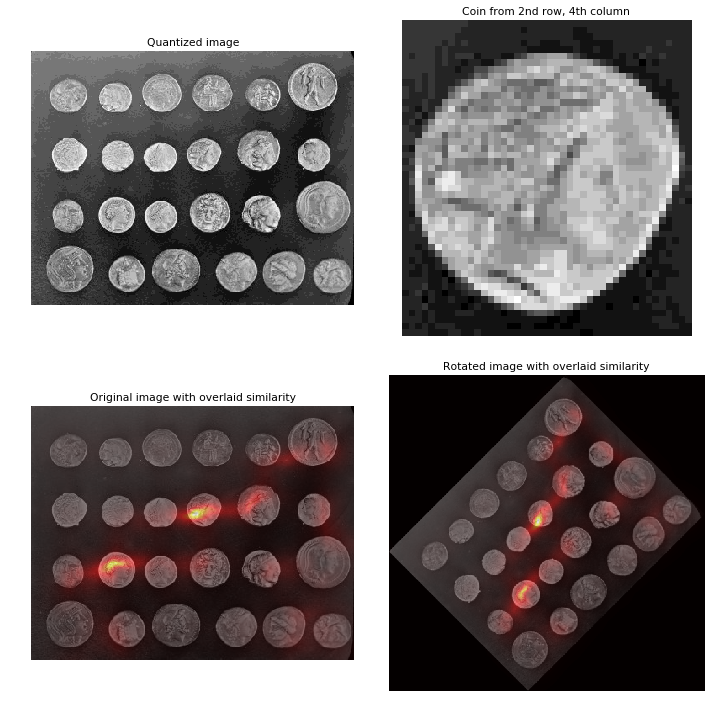

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from skimage import data, transform
from skimage.util import img_as_ubyte
from skimage.morphology import disk
from skimage.filters import rank


matplotlib.rcParams['font.size'] = 9


def windowed_histogram_similarity(image, selem, reference_hist, n_bins):
    # Compute normalized windowed histogram feature vector for each pixel
    px_histograms = rank.windowed_histogram(image, selem, n_bins=n_bins)

    # Reshape coin histogram to (1,1,N) for broadcast when we want to use it in
    # arithmetic operations with the windowed histograms from the image
    reference_hist = reference_hist.reshape((1, 1) + reference_hist.shape)

    # Compute Chi squared distance metric: sum((X-Y)^2 / (X+Y));
    # a measure of distance between histograms
    X = px_histograms
    Y = reference_hist

    num = (X - Y) ** 2
    denom = X + Y
    denom[denom == 0] = np.infty
    frac = num / denom

    chi_sqr = 0.5 * np.sum(frac, axis=2)

    # Generate a similarity measure. It needs to be low when distance is high
    # and high when distance is low; taking the reciprocal will do this.
    # Chi squared will always be >= 0, add small value to prevent divide by 0.
    similarity = 1 / (chi_sqr + 1.0e-4)

    return similarity


# Load the `skimage.data.coins` image
img = img_as_ubyte(data.coins())

# Quantize to 16 levels of greyscale; this way the output image will have a
# 16-dimensional feature vector per pixel
quantized_img = img // 16

# Select the coin from the 4th column, second row.
# Co-ordinate ordering: [x1,y1,x2,y2]
coin_coords = [184, 100, 228, 148]   # 44 x 44 region
coin = quantized_img[coin_coords[1]:coin_coords[3],
                     coin_coords[0]:coin_coords[2]]

# Compute coin histogram and normalize
coin_hist, _ = np.histogram(coin.flatten(), bins=16, range=(0, 16))
coin_hist = coin_hist.astype(float) / np.sum(coin_hist)

# Compute a disk shaped mask that will define the shape of our sliding window
# Example coin is ~44px across, so make a disk 61px wide (2 * rad + 1) to be
# big enough for other coins too.
selem = disk(30)

# Compute the similarity across the complete image
similarity = windowed_histogram_similarity(quantized_img, selem, coin_hist,
                                           coin_hist.shape[0])

# Now try a rotated image
rotated_img = img_as_ubyte(transform.rotate(img, 45.0, resize=True))
# Quantize to 16 levels as before
quantized_rotated_image = rotated_img // 16
# Similarity on rotated image
rotated_similarity = windowed_histogram_similarity(quantized_rotated_image,
                                                   selem, coin_hist,
                                                   coin_hist.shape[0])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

axes[0, 0].imshow(quantized_img, cmap='gray')
axes[0, 0].set_title('Quantized image')
axes[0, 0].axis('off')

axes[0, 1].imshow(coin, cmap='gray')
axes[0, 1].set_title('Coin from 2nd row, 4th column')
axes[0, 1].axis('off')

axes[1, 0].imshow(img, cmap='gray')
axes[1, 0].imshow(similarity, cmap='hot', alpha=0.5)
axes[1, 0].set_title('Original image with overlaid similarity')
axes[1, 0].axis('off')

axes[1, 1].imshow(rotated_img, cmap='gray')
axes[1, 1].imshow(rotated_similarity, cmap='hot', alpha=0.5)
axes[1, 1].set_title('Rotated image with overlaid similarity')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()